# Problem Recognition
- Apply Fast Shapelets on ECG5000 dataset

# Set Environment

In [0]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle


# Import Local package
import sys
sys.path.append('../other')
sys.path.append('..')

# Dataset
from tslearn.datasets import UCR_UEA_datasets
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMinMax

# Fast Shapelets
from sax import SAXExtractor
import other_util
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from shapelet_tree import ShapeletTreeClassifier
from shapelet_tree import extract_shapelets_with_tree
from shapelet_tree import ShapeletTransformer

# Evaluation
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve

# Save Results
import time
from sklearn.externals import joblib
import pickle 


import warnings; warnings.filterwarnings('ignore')

# Data Preparation

In [0]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('ECG5000')

X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

# Reshape for match the scikit-learn data structure
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# Map labels to [0, .., C-1]
map_dict = {}
for j, c in enumerate(np.unique(y_train)):
    map_dict[c] = j
y_train = pd.Series(y_train).map(map_dict).values
y_test = pd.Series(y_test).map(map_dict).values

# Model Fitting

In [0]:
extractor = SAXExtractor(alphabet_size=4, sax_length=16, nr_candidates=10, 
                          iterations=5, mask_size=3)

st_clf = ShapeletTreeClassifier(method=extractor, 
                                min_len=16,
                                max_len=60, 
                                max_depth = 3,
                                min_samples_split = 2,
                                metric=other_util.calculate_ig)

st_clf.fit(X_train,y_train)

In [0]:
# Save Model
output  = '../output' 
path = join(output,'ecg5000_fstree.pkl')
with open(path ,'wb') as f:
    pickle.dump([st_clf.tree],f)


# Evaluation

In [0]:
fstree = st_clf.tree
y_pred = fstree.predict(X_test)
perform_list = []
acc = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test,y_pred)
prfs = precision_recall_fscore_support(y_test,y_pred)
perform_list.append([acc,cm,prfs])
perform_list

[[0.9115555555555556, array([[2575,    9,   38,    5,    0],
         [  38, 1427,   62,   63,    0],
         [  22,   12,   44,    5,    3],
         [  12,   94,   17,   52,    0],
         [   7,   11,    0,    0,    4]]), (array([0.97023361, 0.91886671, 0.27329193, 0.416     , 0.57142857]),
   array([0.98020556, 0.89748428, 0.51162791, 0.29714286, 0.18181818]),
   array([0.97519409, 0.90804963, 0.3562753 , 0.34666667, 0.27586207]),
   array([2627, 1590,   86,  175,   22]))]]

In [0]:
# Save Result
output  = '../output' 
path = join(output,'ecg5000_fstree_performance.pkl')
with open(path ,'wb') as f:
    pickle.dump([perform_list],f)

# Visualization

In [0]:
# Transform dataset by the distance with shapelets
def calculate_distance_matrix(X, shapelets):
    D = np.zeros((len(X), len(shapelets)))
    for smpl_idx, sample in enumerate(X):
        for shap_idx, shapelet in enumerate(shapelets):
            dist = other_util.sdist_no_norm(shapelet.flatten(), sample)
            D[smpl_idx, shap_idx] = dist
    return D

In [0]:
shp_tree = [np.array(x) for x in fstree.extract_all_shapelets()]
X_train_fs = calculate_distance_matrix(X_train,shp_tree)
X_test_fs = calculate_distance_matrix(X_test,shp_tree)

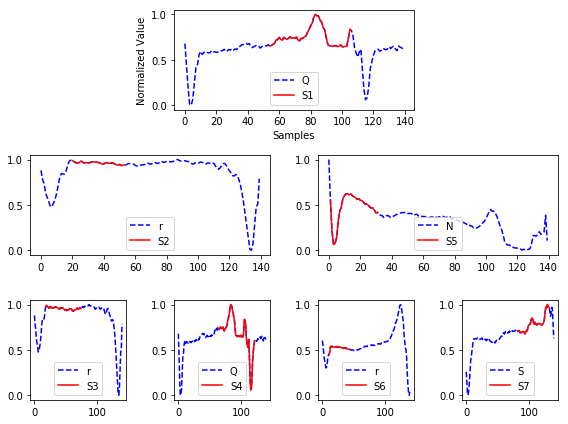

In [0]:
fig = plt.figure(figsize = [8,6])
gs = GridSpec(3, 4, figure=fig)

label_dict = {0:'N', 1 : 'r', 2 : 'V', 3: 'S', 4: 'Q' }
ts_id = np.argmin(X_train_fs,axis=0)

# Node1 : root
ax1 = fig.add_subplot(gs[0, 1:3])
ts = X_train[ts_id[0]]
shp = shp_tree[0]
md,pos = other_util.sdist_with_pos(ts,shp)
ax1.plot(range(len(ts)),ts,label = label_dict[y_train[ts_id[0]]],ls = '--',c='b' )
ax1.plot(range(pos,pos+len(shp)),shp,ls = '-',c='r',label = 'S1')
ax1.legend(loc=8)
ax1.set_xlabel('Samples')
ax1.set_ylabel('Normalized Value')


# Node 2
ax2 = fig.add_subplot(gs[1, :2])
ts = X_train[ts_id[1]]
shp = shp_tree[1]
md,pos = other_util.sdist_with_pos(ts,shp)
ax2.plot(range(len(ts)),ts,label = label_dict[y_train[ts_id[1]]],ls = '--',c='b' )
ax2.plot(range(pos,pos+len(shp)),shp,ls = '-',c='r',label = 'S2')
ax2.legend(loc=8)




# Node3
ax3 = fig.add_subplot(gs[2, 0])
ts = X_train[ts_id[2]]
shp = shp_tree[2]
md,pos = other_util.sdist_with_pos(ts,shp)
ax3.plot(range(len(ts)),ts,label = label_dict[y_train[ts_id[2]]],ls = '--',c='b' )
ax3.plot(range(pos,pos+len(shp)),shp,ls = '-',c='r',label = 'S3')
ax3.legend(loc=8)

# Node 4
ax4 = fig.add_subplot(gs[2, 1])
ts = X_train[ts_id[3]]
shp = shp_tree[3]
md,pos = other_util.sdist_with_pos(ts,shp)
ax4.plot(range(len(ts)),ts,label = label_dict[y_train[ts_id[3]]],ls = '--',c='b' )
ax4.plot(range(pos,pos+len(shp)),shp,ls = '-',c='r',label = 'S4')
ax4.legend(loc=8)

# Node 5
ax5 = fig.add_subplot(gs[1, 2:])
ts = X_train[ts_id[4]]
shp = shp_tree[4]
md,pos = other_util.sdist_with_pos(ts,shp)
ax5.plot(range(len(ts)),ts,label = label_dict[y_train[ts_id[4]]],ls = '--',c='b' )
ax5.plot(range(pos,pos+len(shp)),shp,ls = '-',c='r',label = 'S5')
ax5.legend(loc=8)

# Node 6
ax6 = fig.add_subplot(gs[2, 2])
ts = X_train[ts_id[5]]
shp = shp_tree[5]
md,pos = other_util.sdist_with_pos(ts,shp)
ax6.plot(range(len(ts)),ts,label = label_dict[y_train[ts_id[5]]],ls = '--',c='b' )
ax6.plot(range(pos,pos+len(shp)),shp,ls = '-',c='r',label = 'S6')
ax6.legend(loc=8)

# Node 7
ax7 = fig.add_subplot(gs[2, 3])
ts = X_train[ts_id[6]]
shp = shp_tree[6]
md,pos = other_util.sdist_with_pos(ts,shp)
ax7.plot(range(len(ts)),ts,label = label_dict[y_train[ts_id[6]]],ls = '--',c='b' )
ax7.plot(range(pos,pos+len(shp)),shp,ls = '-',c='r',label = 'S7')
ax7.legend(loc=8)



plt.tight_layout()

# Save Figure
timestr = time.strftime("%Y%m%d-%H%M")
fig_name = "".join((PROJECT_PATH,"/ECG5000_Shapelets_",timestr,".png"))
plt.savefig(fig_name,dpi=100)

plt.show()
